# Практическая работа 5

## Визуализация многомерных данных.

Импортируем библиотеки

In [148]:
import pandas as pd
import numpy as np

import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Глянем на данные, [датасет](https://www.kaggle.com/datasets/vinven7/comprehensive-database-of-minerals) взят по минералам.

In [149]:
df_orig = pd.read_csv("data/Minerals_Database.csv")
df_orig

,Unnamed: 0,Name,Crystal Structure,Mohs Hardness,Diaphaneity,Specific Gravity,Optical,Refractive Index,Dispersion,Hydrogen,...,Acetate,Phosphate,Sulphate,Carbonate,Ammonium,Hydrated Water,count,Molar Mass,Molar Volume,Calculated Density
0,0,Abenakiite-(Ce),5.0,4.50,0.0,3.240,3.0,1.580,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,817.339002,0.123390,5.498
1,1,Abernathyite,4.0,2.75,3.0,3.446,3.0,1.592,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9.0,435.069330,0.056083,6.439
2,2,Abhurite,5.0,2.00,3.0,4.420,3.0,2.085,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,921.092220,0.122631,6.234
3,3,Abswurmbachite,0.0,0.00,0.0,0.000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,550.019900,0.033658,13.563
4,4,Actinolite,2.0,5.50,2.0,1.050,4.0,1.634,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.0,861.185368,0.112074,6.378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,3107,Zoltaiite,0.0,0.00,0.0,0.000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,677.090039,0.067308,8.349
3108,3108,Zugshunstite-(Ce),0.0,0.00,0.0,0.000,0.0,0.000,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,1005.674169,0.280205,2.979
3109,3109,Zvyaginite,0.0,0.00,0.0,0.000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,38.0,1037.626464,0.179472,4.799
3110,3110,Zwieselite,0.0,0.00,0.0,0.000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,225.663765,0.056017,3.344


В датасете у нас есть **химические элементы** (118 штук), входящие в состав минералов, и другие данные о минералах. Посмотрим, можно ли кластеризовать минералы, зная их химический состав и плотность. Плотность у нас будет классом (ниже будет описание).

Возьмем только те столбцы, где содержатся хим. элементы.

In [150]:
import re
chemical_elements = []
reg = "(.*?gen)|(.*?(i|l|n)um$)|(.*?(g|r|b|t|m|n|d|s)on)|(.*?ine)|(.*?rus)|(.*?fur)|(Bismuth)|(Lead)|(Mercury)|(Gold)|(Platinum)|(Tungsten)|(Tin)|(Silver)|(Manganese)|(Cobalt)|(Nickel)|(Copper)|(Zinc)|(Arsenic)"

for key in list(df_orig.keys()):
    if bool(re.search(reg, key)):
        chemical_elements.append(key)

len(chemical_elements)

118

Супер, мы получили 118 хим элементов!

Построим новый датасет

In [151]:
df_new = (df_orig[chemical_elements]).copy()
df_new.head(2)

,Hydrogen,Helium,Lithium,Beryllium,Boron,Carbon,Nitrogen,Oxygen,Fluorine,Sodium,...,Roentgenium,Copernicium,Nihonium,Flerovium,Moscovium,Livermorium,Tennessine,Oganesson,Carbonate,Ammonium
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разобьем минералы на классы по плотности:
* легкие (lungs) – < 2,5 (гипс);
* средние (medium) – 2,5–4,0 (кварц, полевые шпаты);
* тяжелые (heavy) – 4,0–8,0 пирит, халькопирит);
* очень тяжелые (grave) – > 8,0 (киноварь).

In [152]:
df_new['Density'] = np.nan

for i in range(len(df_new['Density'])):
    density = df_orig['Calculated Density'][i]
    if density < 2.5:
        df_new['Density'][i] = 'lungs'
    elif density < 4:
        df_new['Density'][i] = 'medium'
    elif density < 8:
        df_new['Density'][i] = 'heavy'
    elif density > 8:
        df_new['Density'][i] = 'grave'
df_new

,Hydrogen,Helium,Lithium,Beryllium,Boron,Carbon,Nitrogen,Oxygen,Fluorine,Sodium,...,Copernicium,Nihonium,Flerovium,Moscovium,Livermorium,Tennessine,Oganesson,Carbonate,Ammonium,Density
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heavy
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heavy
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heavy
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grave
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grave
3108,12.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
3109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heavy
3110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium


Глянем, что получилось:

In [153]:
df_new['Density'].describe()

count      3112
unique        4
top       heavy
freq       1393
Name: Density, dtype: object

# Подбор k

Поскольку оба метода по заданию использует алгоритм kNN, подберем нормальное k ближайших соседей.

Построим модель

In [154]:
df_tsne = df_new.drop(columns=['Density'], axis=1)

# scaler = preprocessing.MinMaxScaler()
# df_tsne = pd.DataFrame(scaler.fit_transform(df_tsne), columns=df_tsne.columns)

X = df_tsne
y = df_new['Density']
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K = 4 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K = 4 is 0.608346709470305


f1_score: 0.6147672552166934 at K = 0
f1_score: 0.608346709470305 at K = 3
f1_score: 0.6051364365971108 at K = 8


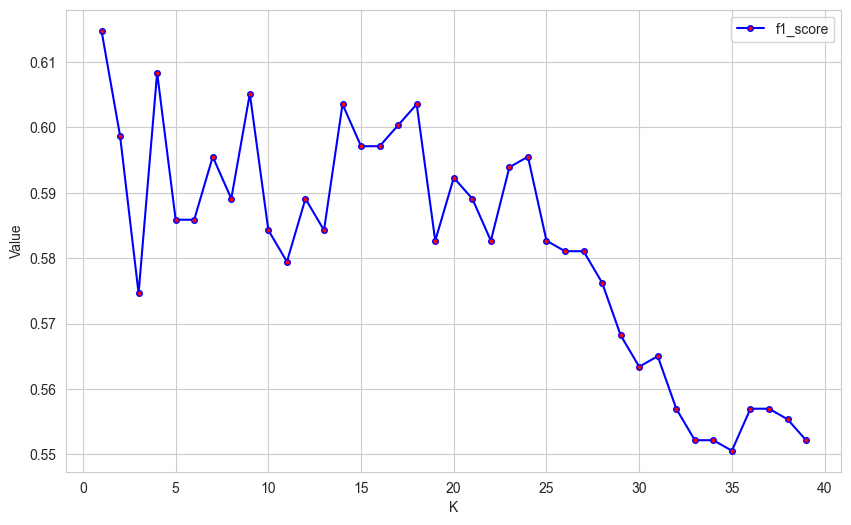

In [155]:
f1_score = []

from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    f1_score.append(metrics.f1_score(y_test, yhat, average='micro'))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),f1_score,color = 'blue', marker='o',markerfacecolor='red', markersize=4)
plt.legend(['f1_score'])
plt.xlabel('K')
plt.ylabel('Value')

for i in range(1,4):
    print("f1_score:",sorted(f1_score)[-i],"at K =",f1_score.index(sorted(f1_score)[-i]))

Иронично, но оптимального k нет (f1 метрика слабовата), ну да ладно.

###  Построим T-SNE

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



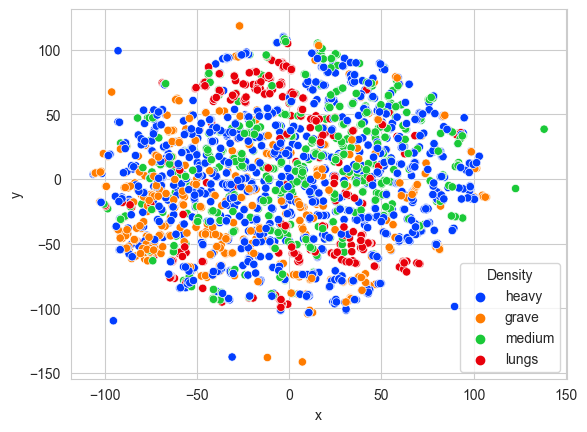

In [156]:
model = TSNE(n_components=2, perplexity=3)
TSNE_features = model.fit_transform(df_tsne)

data=df_tsne.copy()
data['x'] = TSNE_features[:,0]
data['y'] = TSNE_features[:,1]

fig = plt.figure()
sns.scatterplot(x='x', y='y', hue=df_new['Density'], data=data, palette='bright')
plt.show()

# Визуализация без heavy
Обратим внимание на  то, что heavy плотность распределена по всей области, уберем ее.

In [157]:
df_no_heavy = df_new.loc[df_new['Density'] != 'heavy'].reset_index()
df_no_heavy

,index,Hydrogen,Helium,Lithium,Beryllium,Boron,Carbon,Nitrogen,Oxygen,Fluorine,...,Copernicium,Nihonium,Flerovium,Moscovium,Livermorium,Tennessine,Oganesson,Carbonate,Ammonium,Density
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grave
1,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
2,8,14.0,0.0,0.0,0.0,6.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lungs
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
4,14,24.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,3101,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
1715,3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
1716,3107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grave
1717,3108,12.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium


In [158]:
df_tsne = df_no_heavy.drop(columns=['Density', 'index'], axis=1)

# scaler = preprocessing.MinMaxScaler()
# df_tsne = pd.DataFrame(scaler.fit_transform(df_tsne), columns=df_tsne.columns)

X = df_tsne
y = df_no_heavy['Density']
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=4 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=4 is 0.7151162790697675


Метрика f1 не намного, но лучше)))

f1_score: 0.741279069767442 at K = 0
f1_score: 0.7296511627906975 at K = 2
f1_score: 0.7296511627906975 at K = 2
f1_score: 0.7296511627906975 at K = 2


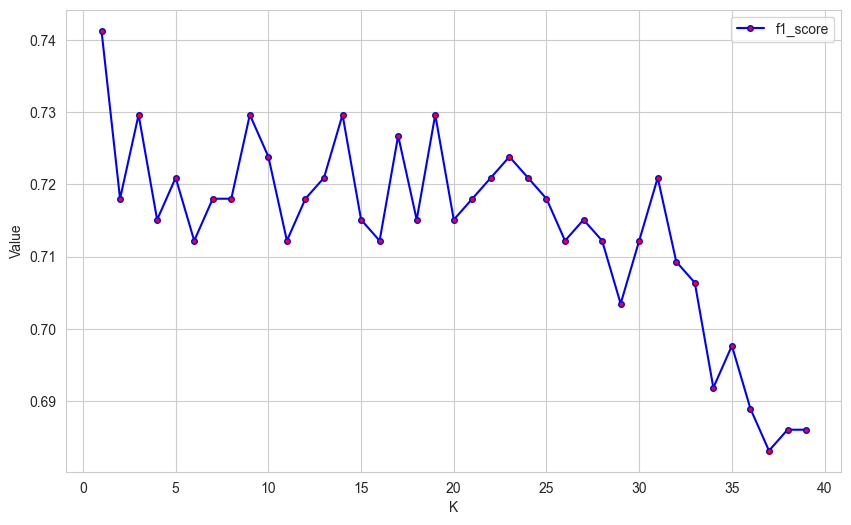

In [159]:
f1_score = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    f1_score.append(metrics.f1_score(y_test, yhat, average='micro'))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),f1_score,color = 'blue', marker='o',markerfacecolor='red', markersize=4)
plt.legend(['f1_score'])
plt.xlabel('K')
plt.ylabel('Value')

for i in range(1,5):
    print("f1_score:",sorted(f1_score)[-i],"at K =",f1_score.index(sorted(f1_score)[-i]))

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



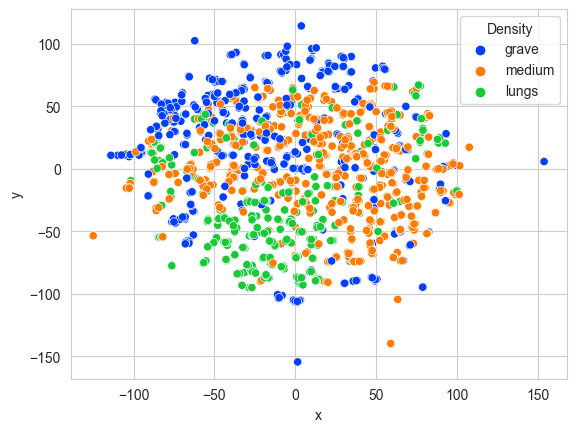

In [160]:
model = TSNE(n_components=2, perplexity=2)
TSNE_features = model.fit_transform(df_tsne)

data=df_tsne.copy()
data['x'] = TSNE_features[:,0]
data['y'] = TSNE_features[:,1]

fig = plt.figure()
sns.scatterplot(x='x', y='y', hue=df_no_heavy['Density'], data=data, palette='bright')
plt.show()

Намного лучше, тут даже можно условные кластеры выделить.

Сделаем то же самое через **umap**.

In [161]:
import umap.umap_ as umap

def draw_umap(n_neighbors=10, min_dist=0.1, metric='euclidean'):
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    u = fit.fit_transform(data)
    df_u = pd.DataFrame(u, columns = ['x','y'])
    df_u['classes'] = df_no_heavy['Density']
    fig = px.scatter(df_u, x="x", y="y", color="classes")
    fig.update_layout(title=f'Graphic for n_neighbors = {n_neighbors} and distance = {min_dist}', title_font_size=20)
    fig.show()

draw_umap(n_neighbors=25, min_dist=0.1)
draw_umap(n_neighbors=25, min_dist=0.6)
draw_umap(n_neighbors=50, min_dist=0.1)
draw_umap(n_neighbors=50, min_dist=0.6)

# Рассчитаем время

t_SNE

In [162]:
model = TSNE(n_components=2, perplexity=2)
%time TSNE_features = model.fit_transform(df_tsne)

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



CPU times: total: 23.7 s
Wall time: 45.3 s


UMAP

In [163]:
%time u = umap.UMAP(n_neighbors=3, min_dist=0.1).fit_transform(data)

D:\PyCharm Projects\MIREA\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



CPU times: total: 13.3 s
Wall time: 9.9 s


# Вывод

Судить о прямой закономерности сложно, но визуально можно построить кластеры для всех групп плотности, кроме очень тяжелых минералов.